<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/main/two4two_sickones_explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pathlib
import os
from pathlib import Path
import random
import datetime

import numpy as np
from PIL import Image

from skimage.transform import resize

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2024-08-05 14:10:50.960695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Params

In [5]:
load_checkpoints = True

modeltype = 'mobilenet'

biased_ds = None
nobias_ds = 'sick_ones_bendbias'

epochs = 10
learning_rate = 0.0001

# Setup and Load Datasets

In [6]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

def load_data_gens(trainval_datadir, test_datadir):
  train_df = load_dataframe(trainval_datadir, 'train')
  valid_df = load_dataframe(trainval_datadir, 'validation')
  test_df = load_dataframe(test_datadir, 'test')

  datagen = ImageDataGenerator(rescale=1./255)
  train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=trainval_datadir / 'train', target_size=(128, 128),
                                                x_col='filename', y_col='ill', batch_size=64, shuffle=True)
  valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, directory=trainval_datadir / 'validation', target_size=(128, 128),
                                                x_col='filename', y_col='ill', batch_size=64, shuffle=False)
  test_generator = datagen.flow_from_dataframe(dataframe=test_df, directory=test_datadir / 'test',  target_size=(128, 128),
                                               x_col='filename', y_col='ill',
                                               batch_size=64, shuffle=False)

  return train_generator, valid_generator, test_generator

In [7]:
gdrive = Path('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive')
relative_model_path = "two4two_sickones_models"
base_path = gdrive / relative_model_path

output = gdrive / 'hcxai' / 'blocky_diagnosis'

base_path

PosixPath('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/two4two_sickones_models')

In [8]:
data_dir_sickones = keras.utils.get_file(
    origin = "file:///Users/djohnson/sciebo/1. Research/1. HCXAI/1. Projects/two4two_datasets/two4two_datasets.tar.gz",
    fname = 'two4two_datasets.tar.gz',
    extract = True,
    archive_format = 'tar'
)
data_dir_sickones = Path(data_dir_sickones)

## Load Biased and Unbiased datasets

In [9]:
nobias_dir = data_dir_sickones.with_suffix('').with_suffix('') / nobias_ds
biased_dir = data_dir_sickones.with_suffix('').with_suffix('') / biased_ds if biased_ds is not None else None

nobias_dir, biased_dir

(PosixPath('/Users/djohnson/.keras/datasets/two4two_datasets/sick_ones_bendbias'),
 None)

In [10]:
nobias_model_path = base_path / nobias_ds / f'{modeltype}'
biased_model_path = base_path / biased_ds / f'{modeltype}' if biased_ds is not None else None

nobias_model_path, biased_model_path

(PosixPath('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/two4two_sickones_models/sick_ones_bendbias/mobilenet'),
 None)

In [11]:
nobias_model_exists = os.path.exists(nobias_model_path)
biased_model_exists = os.path.exists(biased_model_path) if biased_ds is not None else False

nobias_model_exists, biased_model_exists

(True, False)

In [12]:
# Load Dataframes
nobias_train_df,  nobias_valid_df, nobias_test_df = (load_dataframe(nobias_dir, 'train'),
                                                     load_dataframe(nobias_dir, 'validation'),
                                                     load_dataframe(nobias_dir, 'test'))
nobias_train_df['sphere_diff'] = np.abs(nobias_train_df['spherical'] - nobias_train_df['ill_spherical'])
nobias_valid_df['sphere_diff'] = np.abs(nobias_valid_df['spherical'] - nobias_valid_df['ill_spherical'])
nobias_test_df['sphere_diff'] = np.abs(nobias_test_df['spherical'] - nobias_test_df['ill_spherical'])

if biased_ds is not None:
    biased_train_df,  biased_valid_df, biased_test_df = (load_dataframe(biased_dir, 'train'),
                                                        load_dataframe(biased_dir, 'validation'),
                                                        load_dataframe(biased_dir, 'test'))
    biased_train_df['sphere_diff'] = np.abs(biased_train_df['spherical'] - biased_train_df['ill_spherical'])
    biased_valid_df['sphere_diff'] = np.abs(biased_valid_df['spherical'] - biased_valid_df['ill_spherical'])
    biased_test_df['sphere_diff'] = np.abs(biased_test_df['spherical'] - biased_test_df['ill_spherical'])

In [13]:
# Load Data Gens
nobias_train_gen, nobias_valid_gen, nobias_test_gen = load_data_gens(nobias_dir, nobias_dir)
biased_train_gen, biased_valid_gen, biased_test_gen = load_data_gens(biased_dir, biased_dir)if biased_ds is not None else None, None, None

Found 80000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


# Model Loading and Evaluation

In [14]:
def get_model(load_checkpoint: bool, model_filepath: Path, learning_rate: float):

  if load_checkpoint:
    model = keras.models.load_model(model_filepath)
    print(f'loading existing checkpoint for mobilenet - {model_filepath}')
  else:
    print('Model does not exist or checkpoint not set to be loaded. Loading new mobilenet.')
    base_model = keras.applications.MobileNetV2(
        input_shape=(128, 128, 3),
        alpha=1.0,
        include_top=False,
        weights=None,
        input_tensor=None,
        pooling='avg'
    )

    model = keras.Sequential([
        base_model,
        layers.Dense(2, activation="softmax"),
    ])

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt, metrics=["accuracy"])

  return model

def get_simple_model(load_checkpoint: bool, model_filepath: Path, learning_rate: float):


  if load_checkpoint:
    model = keras.models.load_model(model_filepath)
    print(f'loading existing checkpoint for simple net- {model_filepath}')
  else:
    print('Model does not exist or checkpoint not set to be loaded. Loading new simple net.')
    model = keras.models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"),
    ])

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt, metrics=["accuracy"])

  return model

In [15]:
def eval(model, test_generator):

  print(f'Evaluating model on test data')
  return model.evaluate(test_generator)[1]

## Load Model

### No Bias Model

In [16]:
if modeltype == 'mobilenet':
  nobias_model = get_model(load_checkpoint=True,
                           model_filepath=nobias_model_path,
                           learning_rate=learning_rate)
elif modeltype == 'simple':
  nobias_model = get_simple_model(load_checkpoint=True,
                                  model_filepath=nobias_model_path,
                                  learning_rate=learning_rate)
else:
  print('Model type does not exist')
  nobias_model = None

loading existing checkpoint for mobilenet - /Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/two4two_sickones_models/sick_ones_bendbias/mobilenet


In [17]:
nobias_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2226434 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


## Eval  Model

### No Bias Model

In [18]:
# results on nobias test
acc = eval(nobias_model, nobias_test_gen)
print(f'ACC: {acc}')
probs = nobias_model.predict(nobias_test_gen)
preds = np.argmax(probs, axis=-1)

nobias_test_df['nobias_pred'] = preds
nobias_test_df['nobias_pred'] = nobias_test_df['nobias_pred'].astype(str)
(nobias_test_df['nobias_pred'] == nobias_test_df['ill']).astype(int).mean()

Evaluating model on test data
47/47 [==============================] - 18s 359ms/step - loss: 0.3597 - accuracy: 0.8603
ACC: 0.8603333234786987
47/47 [==============================] - 18s 360ms/step


0.8603333333333333

# Explanations

## Generate Explanation Dataset

Select 20 images to represent challenging decision making tasks but where there is a clear final decision.

(for now from nobias dataset with biased model predictions)

- 16 - Correct predictions
- 4 - Incorrect predictions

represents accuracy of model (around $80\%$)

(actually I think this does not matter.  a small sample of 20 samples will be the same as teh original model, especially in hard cases.

Will instead pick 6 total from each category

- Correct Predictions (3 each Correct and 3 Incorrect)
  - medhigh sphere diff and lowmed bend (**overlap** - ill and notill)
  - lowmed sphere diff but medhigh bend (**overlap** - ill and notill)
  - medhigh sphere diff and medhigh bend (**easy** - ill)
  - lowmed sphere diff and lowmed bend (**easy** - ill)
  - lowmed sphere diff but (1,3) changed pieces (**slightly difficult** - does XAI help show ambiguous pieces)


In [19]:
def display_images(df, n_rows, n_cols, img_dir, title, random_state=0):
  """ Function to display images in a grid randomly selected from a dataframe of images.

  Args:
    df (pd.DataFrame): dataframe of images
    n_rows (int): number of rows in the grid
    n_cols (int): number of columns in the grid
    title (str): title of the plot
    random_state (int): random state for reproducibility
  """

  if n_rows == 0 and n_cols == 0:
    print(f'Not data to display for Figure - {title}')
    return

  if n_rows * n_cols < len(df):
    df = df.sample(n_rows * n_cols, random_state=random_state)

  figsize = (n_cols * 2, n_rows*2.5)
  print(figsize)

  test_images = np.array([Image.open(p).convert('RGB') for p in img_dir / df['filename']]) * 1. / 255
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  axes = np.array(axes)
  for i, (ax, idx) in enumerate(zip(axes.flat, df.index)):
    ax.imshow(test_images[i])
    ax.set_title(f'Idx: {idx} - True={df.loc[idx]["ill"]}')
    ax.axis('off')

  fig.suptitle(title)
  fig.tight_layout()

### Correct Samples Selection


In [20]:
ill_rows = nobias_test_df['ill'] == '1'
notill_rows = nobias_test_df['ill'] == '0'

correct_rows = nobias_test_df['nobias_pred'] == nobias_test_df['ill']
incorrect_rows = nobias_test_df['nobias_pred'] != nobias_test_df['ill']

num_diff_is1 = (nobias_test_df['num_diff'] == 1)
num_diff_is2 = (nobias_test_df['num_diff'] == 2)
num_diff_is3 = (nobias_test_df['num_diff'] == 3)

In [21]:
diff_overlap = (abs(nobias_test_df[ill_rows]['sphere_diff']).min(), abs(nobias_test_df[notill_rows]['sphere_diff']).max()) 
bend_overlap = (abs(nobias_test_df[ill_rows]['bending']).min(), abs(nobias_test_df[notill_rows]['bending']).max())

# border of ill
bend_i_border = abs(nobias_test_df[ill_rows]['bending']).min()
diff_i_border = abs(nobias_test_df[ill_rows]['sphere_diff']).min()

# border of notill
bend_n_border = abs(nobias_test_df[notill_rows]['bending']).max()
diff_n_border = abs(nobias_test_df[notill_rows]['sphere_diff']).max()

print(diff_overlap, diff_i_border, diff_n_border)
print(bend_overlap, bend_i_border, bend_n_border)

(0.362658540014537, 0.499981615443567) 0.362658540014537 0.499981615443567
(0.125781852071976, 0.24985742073782502) 0.125781852071976 0.24985742073782502


In [22]:
def check_range(df, column, range):
    return (abs(df[column]) > range[0]) & (abs(df[column]) < range[1])

In [23]:

# Harder Cases
# case 1 - Overlapping Sphere Diff and Not Ill Border Bend
c1_title = 'Overlapping Sphere Diff and Not Ill Bordering Bend'
c1_i = check_range(nobias_test_df, 'sphere_diff', diff_overlap) & check_range(nobias_test_df, 'bending', (bend_n_border, bend_n_border + 0.05))
c1_n = check_range(nobias_test_df, 'sphere_diff', diff_overlap) & check_range(nobias_test_df, 'bending', (bend_n_border - 0.05, bend_n_border))

# case 2 - Not Ill Border Sphere Diff and Overlapping Bend
c2_title = 'Not Ill Border Sphere Diff and Overlapping Bend'
c2_i = check_range(nobias_test_df, 'bending', bend_overlap) & check_range(nobias_test_df, 'sphere_diff', (diff_n_border, diff_n_border + 0.1))
c2_n = check_range(nobias_test_df, 'bending', bend_overlap) & check_range(nobias_test_df, 'sphere_diff', (diff_n_border - 0.1, diff_n_border))

# Case 3 = Overlapping Sphere Diff anid Ill Border Bend
c3_title = 'Overlapping Sphere Diff anid Ill Border Bend'
c3_i = check_range(nobias_test_df, 'sphere_diff', diff_overlap) & check_range(nobias_test_df, 'bending', (bend_i_border, bend_i_border + 0.10))
c3_n = check_range(nobias_test_df, 'sphere_diff', diff_overlap) & check_range(nobias_test_df, 'bending', (bend_i_border - 0.10, bend_i_border))

# case 4 - Ill Border Sphere Diff and Overlapping Bend
c4_title = 'Ill Border Sphere Diff and Overlapping Bend'
c4_i = check_range(nobias_test_df, 'bending', bend_overlap) & check_range(nobias_test_df, 'sphere_diff', (diff_i_border, diff_i_border + 0.1))
c4_n = check_range(nobias_test_df, 'bending', bend_overlap) & check_range(nobias_test_df, 'sphere_diff', (diff_i_border - 0.1, diff_i_border))

## Easier Cases
# Case 5 - Bordering Sphere Diff and Bordering Bend
c5_title = 'Ill Bordering Sphere Diff and Ill Bordering Bend'
c5_i = check_range(nobias_test_df, 'sphere_diff', (diff_i_border, diff_i_border + 0.1)) & check_range(nobias_test_df, 'bending', (bend_i_border, bend_i_border + 0.05))
c5_n = check_range(nobias_test_df, 'sphere_diff', (diff_n_border - 0.1, diff_n_border)) & check_range(nobias_test_df, 'bending', (bend_n_border - 0.05, bend_n_border))

# Case 6 - Low Sphere Diff and 1 or 3 Different Shapes
c6_title = 'Low Sphere Diff and 1 or 3 Different Shapes'
c6_i = check_range(nobias_test_df, 'sphere_diff', diff_overlap) & num_diff_is3
c6_n = check_range(nobias_test_df, 'sphere_diff', diff_overlap) & num_diff_is1

In [24]:
case1_i = num_diff_is2 & ill_rows & correct_rows & c1_i
case1_n = num_diff_is2 & notill_rows & correct_rows & c1_n

case2_i = num_diff_is2 & ill_rows & correct_rows & c2_i
case2_n = num_diff_is2 & notill_rows & correct_rows & c2_n

case3_i = num_diff_is2 & ill_rows & correct_rows & c3_i
case3_n = num_diff_is2 & notill_rows & correct_rows & c3_n

case4_i = num_diff_is2 & ill_rows & correct_rows & c4_i
case4_n = num_diff_is2 & notill_rows & correct_rows & c4_n

case5_i = num_diff_is2 & ill_rows & correct_rows & c5_i
case5_n = num_diff_is2 & notill_rows & correct_rows & c5_n

case6_i = ill_rows & correct_rows & c6_i
case6_n = notill_rows & correct_rows & c6_n


In [25]:
correct_cases = case1_i | case1_n | case2_i | case2_n | case3_i | case3_n | case4_i | case4_n | case5_i | case5_n 
correct_xai_df = pd.concat([nobias_test_df[correct_cases & ill_rows].sample(10, random_state=0), 
                            nobias_test_df[correct_cases & notill_rows].sample(10, random_state=0),
                            nobias_test_df[case6_i & ill_rows].sample(2, random_state=0),
                            nobias_test_df[case6_n & notill_rows].sample(2, random_state=0)])
correct_xai_df.describe()

,spherical,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,obj_rotation_yaw,position_x,position_y,arm_position,obj_color,bg_color,original_id,sphere_diff
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,0.0,24.000000
mean,0.429992,0.426220,2.000000,-0.050387,0.080164,0.041774,-1.261640,-0.419228,-0.390788,0.548497,0.584432,0.601197,NaN,0.455118
std,0.398617,0.221424,0.417029,0.218858,0.437096,0.444207,0.547991,0.244310,0.218024,0.202438,0.281729,0.255021,NaN,0.080404
min,0.000736,0.006505,1.000000,-0.319992,-0.590457,-0.784886,-2.208081,-0.783732,-0.716994,0.070350,0.046649,0.132617,NaN,0.266168
25%,0.018408,0.278888,2.000000,-0.242890,-0.251419,-0.287373,-1.594521,-0.617015,-0.580096,0.431779,0.328192,0.379223,NaN,0.421207
50%,0.436493,0.516198,2.000000,-0.153240,0.152311,0.072100,-1.408168,-0.402796,-0.414807,0.533211,0.683238,0.670868,NaN,0.455295
75%,0.726298,0.559919,2.000000,0.178637,0.440277,0.421773,-0.884727,-0.274825,-0.195442,0.702057,0.806322,0.814269,NaN,0.489904
max,0.999961,0.917124,3.000000,0.288280,0.776974,0.769535,-0.060332,-0.012507,-0.015100,0.924001,0.944488,0.924701,NaN,0.589632


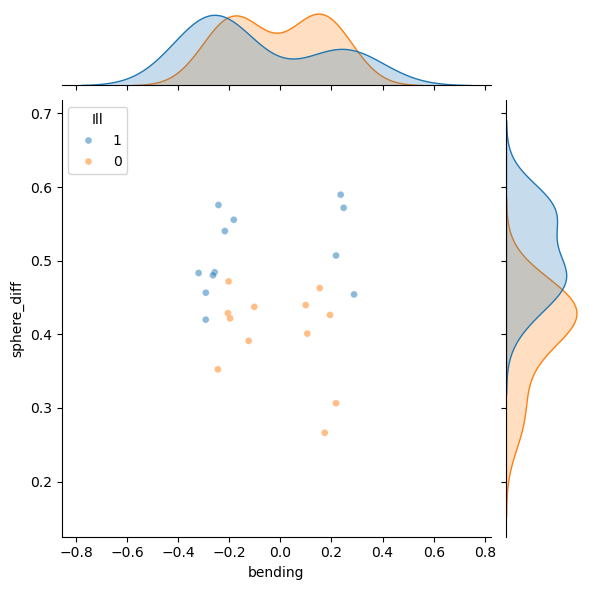

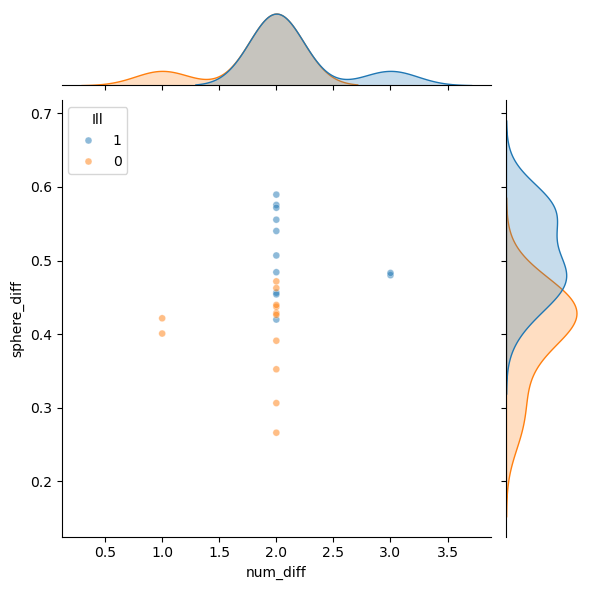

In [26]:
g = sns.jointplot(data=correct_xai_df, x='bending', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

g = sns.jointplot(data=correct_xai_df, x='num_diff', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

(12, 10.0)


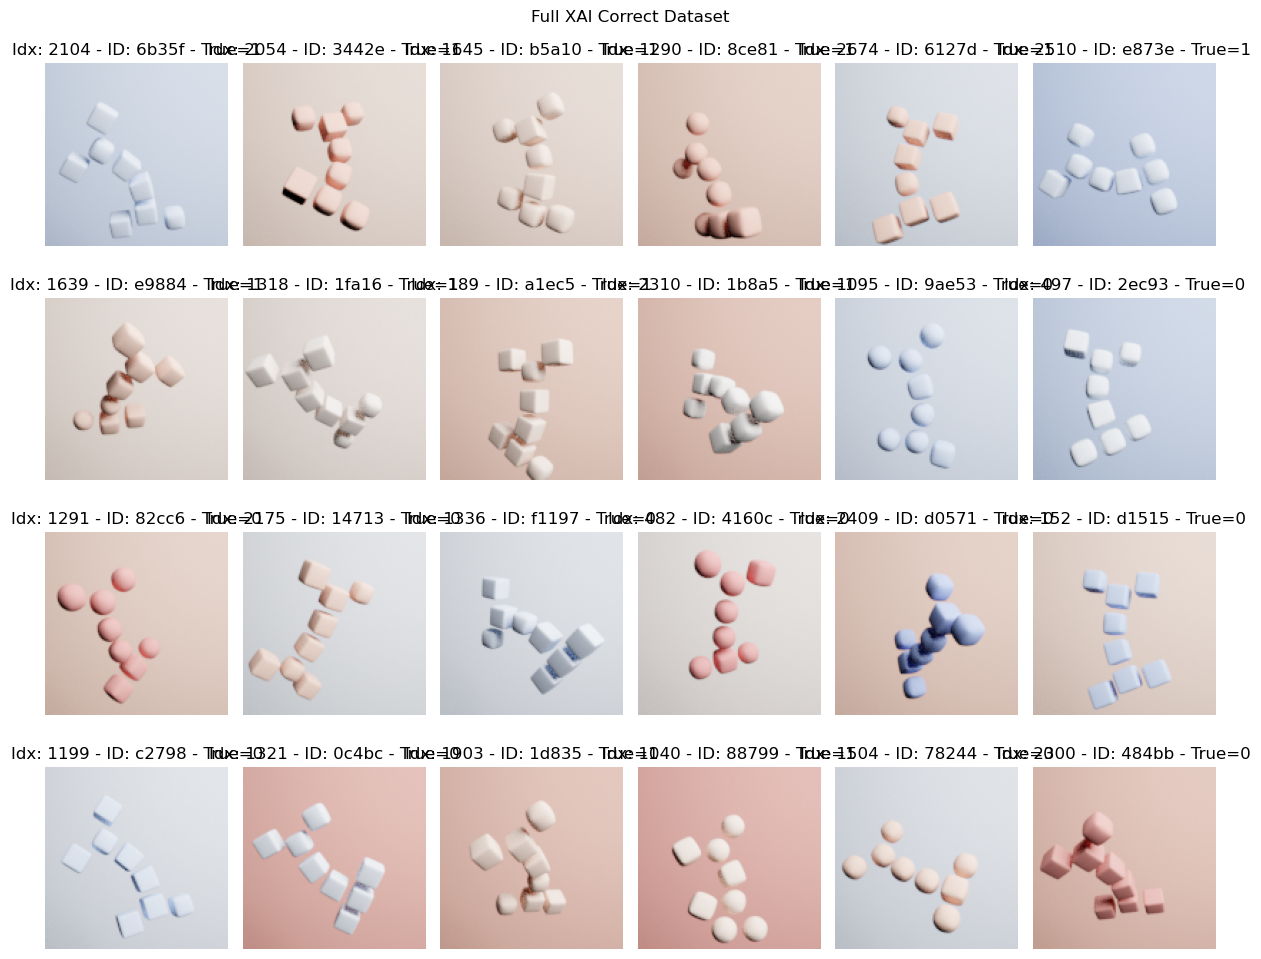

In [27]:
display_images(correct_xai_df, 4, 6, nobias_dir / 'test', f'Full XAI Correct Dataset', random_state=0)

### Incorrect Samples Selection

In [28]:
case1_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c1_i
case1_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c1_n

case2_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c2_i
case2_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c2_n

case3_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c3_i
case3_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c3_n

case4_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c4_i
case4_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c4_n

case5_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c5_i
case5_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c5_n

case6_i_inc = ill_rows & incorrect_rows & c6_i
case6_n_inc = notill_rows & incorrect_rows & c6_n

In [29]:
incorrect_cases = case1_i_inc | case1_n_inc | case2_i_inc | case2_n_inc | case3_i_inc | case3_n_inc | case4_i_inc | case4_n_inc | case5_i_inc | case5_n_inc
incorrect_xai_df = pd.concat([nobias_test_df[incorrect_cases & ill_rows].sample(5, random_state=0), 
                            nobias_test_df[incorrect_cases & notill_rows].sample(5, random_state=0),
                            nobias_test_df[case6_i_inc & ill_rows].sample(1, random_state=0),
                            nobias_test_df[case6_n_inc & notill_rows].sample(1, random_state=0)])
incorrect_xai_df.describe()

,spherical,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,obj_rotation_yaw,position_x,position_y,arm_position,obj_color,bg_color,original_id,sphere_diff
count,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,0.0,12.000000
mean,5.224227e-01,0.525998,2.000000,0.007008,-0.005334,-0.083806,-0.887463,-0.384704,-0.286572,0.551416,0.504095,0.466521,NaN,0.437070
std,4.443113e-01,0.204523,0.426401,0.209583,0.533699,0.581357,0.584244,0.189334,0.270784,0.207672,0.268611,0.239050,NaN,0.095902
min,1.176746e-12,0.242348,1.000000,-0.241241,-0.746362,-0.764848,-1.614467,-0.711311,-0.799294,0.074299,0.119097,0.072515,NaN,0.296808
25%,3.613129e-03,0.371757,2.000000,-0.180051,-0.432495,-0.704298,-1.389034,-0.510253,-0.418120,0.478031,0.321026,0.284729,NaN,0.354827
50%,6.488930e-01,0.559139,2.000000,0.003371,0.158793,-0.056331,-1.032077,-0.303760,-0.202146,0.561242,0.537443,0.501260,NaN,0.431892
75%,9.618862e-01,0.606830,2.000000,0.219040,0.336896,0.449194,-0.344993,-0.261632,-0.068275,0.665181,0.692981,0.613535,NaN,0.507959
max,9.999958e-01,0.986112,3.000000,0.221028,0.745494,0.671330,-0.087609,-0.101649,-0.004501,0.924457,0.888468,0.922666,NaN,0.570473


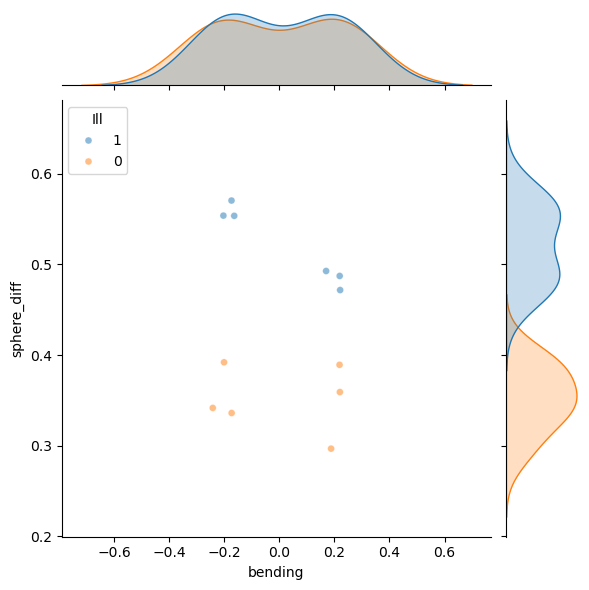

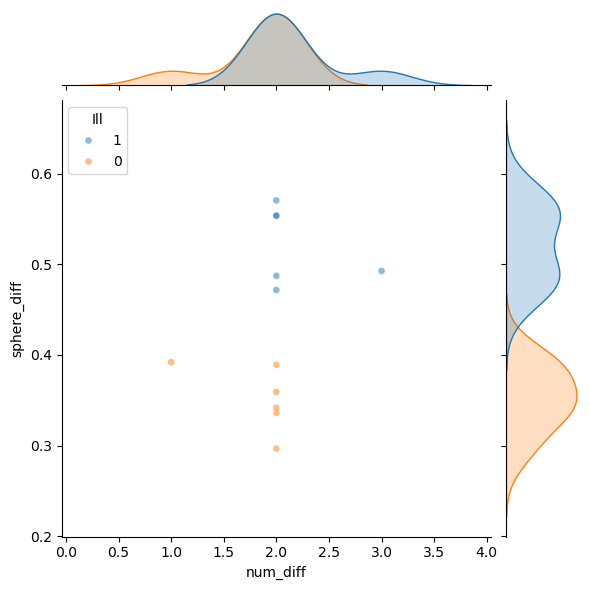

In [30]:
g = sns.jointplot(data=incorrect_xai_df, x='bending', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

g = sns.jointplot(data=incorrect_xai_df, x='num_diff', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

(12, 5.0)


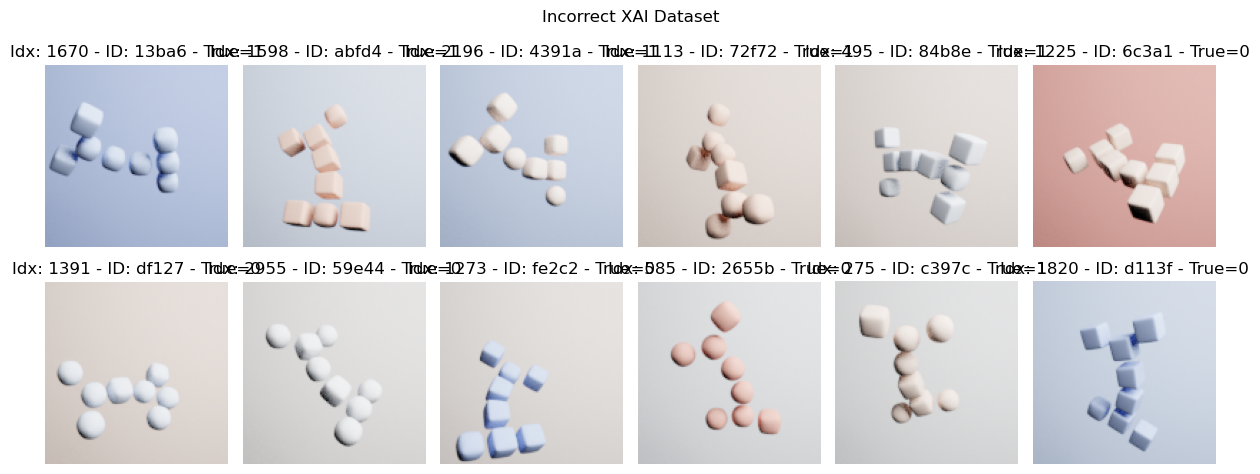

In [31]:
display_images(incorrect_xai_df, 2, 6, nobias_dir / 'test', 'Incorrect XAI Dataset')

### Combine Selections

In [32]:
final_xai_df = pd.concat([correct_xai_df, incorrect_xai_df])
len(final_xai_df), (final_xai_df['nobias_pred'] == final_xai_df['ill']).astype(int).mean()

(36, 0.6666666666666666)

(12, 15.0)


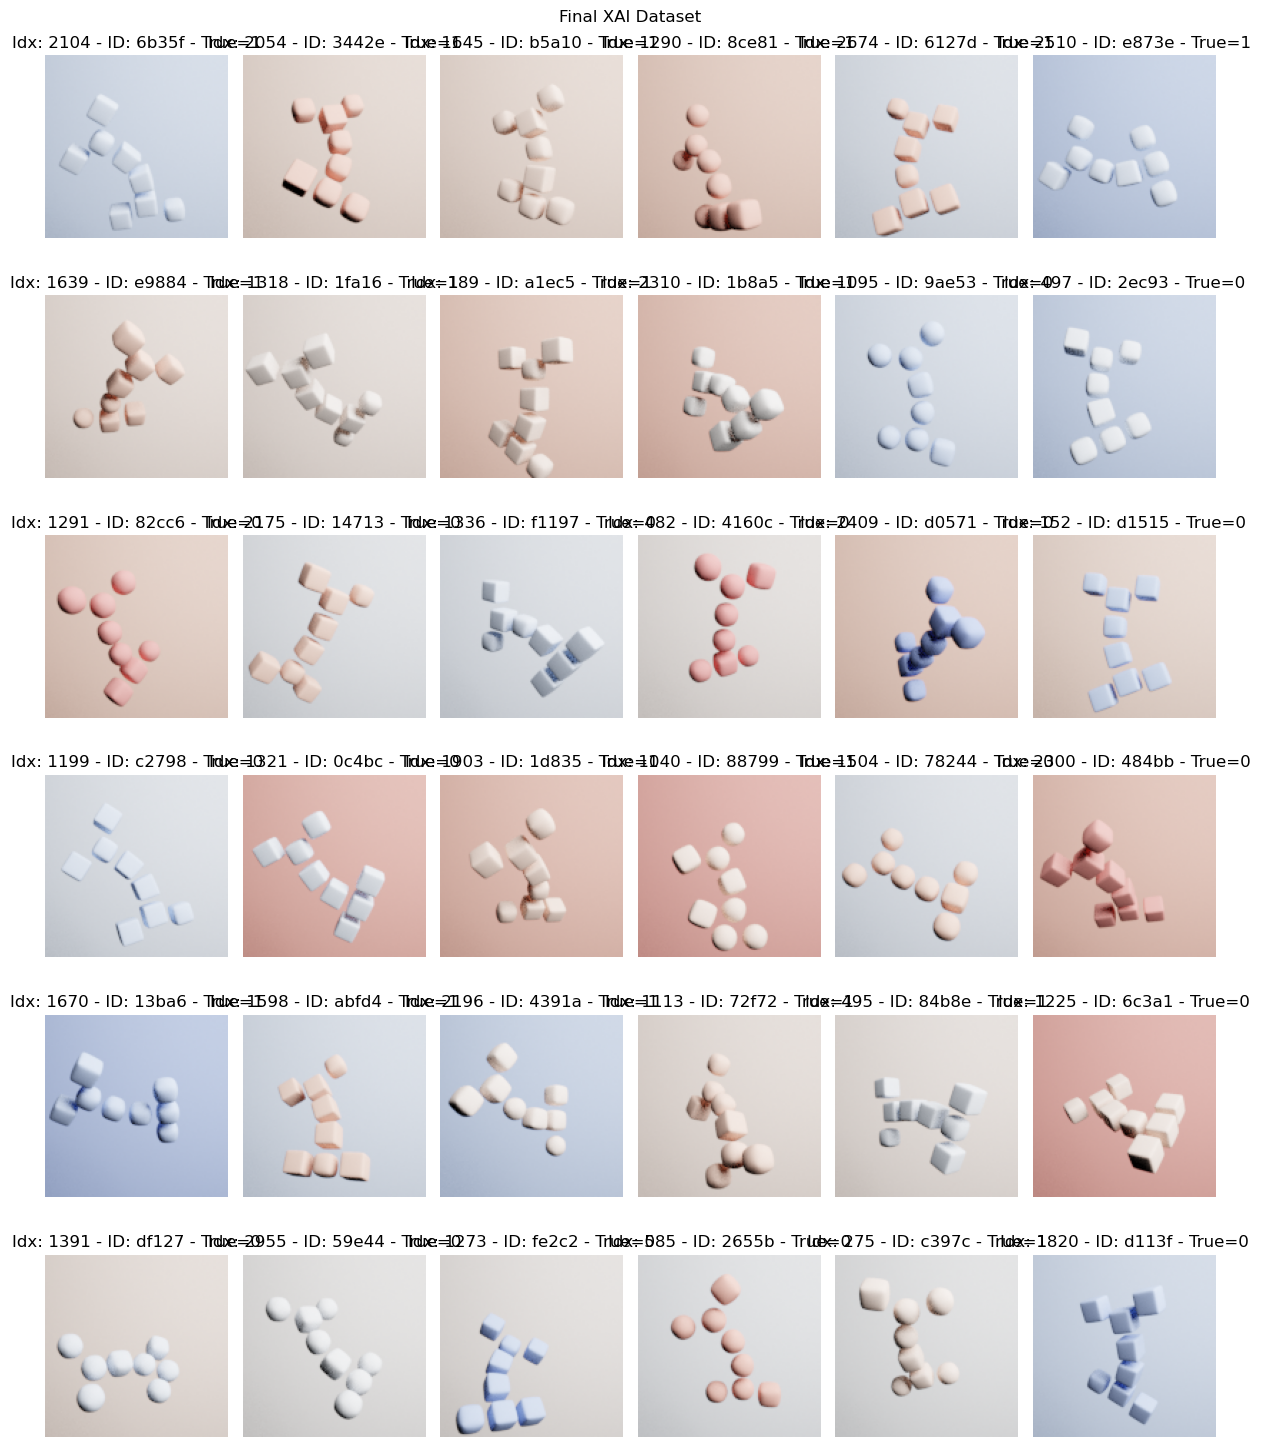

In [33]:
display_images(final_xai_df, 6, 6, nobias_dir / 'test', 'Final XAI Dataset')

In [34]:
xai_images = np.array([Image.open(p).convert('RGB') for p in nobias_dir / 'test' / final_xai_df['filename']]) * 1. / 255

#### Save Inputs

In [325]:
def show_blocky(image, id, pred=None):

  figsize = [5, 5]
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

  #plot the input image
  input_img = resize(image, (256, 256))
  ax.imshow(image)
  title = f'ID: {id[-5:]}'
  if pred is not None:
      title += f' - Model Recomendation = {"Healthy" if pred == "0" else "Cancer"}'
  ax.set_title(title)
  ax.axis('off')

In [330]:
include_pred = True
today = datetime.datetime.today()
date_str = today.strftime('%Y-%m-%d')

o = output / 'original_input' / ' nobias_model' / date_str / f'xai_samples{"_withpreds" if include_pred else "_nopreds"}'
os.makedirs(o, exist_ok=True)
print(f'saving to {o}')

for i, ((idx, row), image) in enumerate(zip(final_xai_df.iterrows(), xai_images)):
  show_blocky(image, row["id"], row["nobias_pred"] if include_pred else None)
  plt.savefig(o / f'{row["id"]}_true={row["ill"]}_pred={row["nobias_pred"]}_input.png')
  # plt.show()
  plt.close()

saving to /Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/hcxai/blocky_diagnosis/original_input/ nobias_model/2024-08-02/xai_samples_withpreds
